#  Fashion-MNIST Classification with a Feedforward NN using NumPy

## Project Outline
#### In this project, you will explore:
* Fundamentals of feedforward neural networks (NNs).
* Constructing a simple NN from the ground up using NumPy to grasp the mechanics of forward and back propagation, as well as optimization.
* Gradient validation through finite-difference approximation.
* Mini-batch gradient descent with momentum for efficient training.
* Regularization techniques and basic hyperparameter tuning strategies to enhance NN performance.

#### Project Stages

* **Stage 1: Library Imports, Data Loading, and Preprocessing**
* **Stage 2: Neural Network Construction and Propagation**
  * 2.1 Dataset Structure Analysis
  * 2.2 Model Building and Forward Propagation
    * Parameter Initialization
    * Activation Function Definitions
    * Forward Propagation Implementation
  * 2.3 Loss Function and Backward Propagation
    * Cross-Entropy Loss Implementation
    * Backward Propagation Implementation
    * Exploring Gradient Checking with Finite-Difference Approximation
* **Stage 3: Network Training and Performance Evaluation**
  * 3.1 Network Training Process
  * 3.2 Model Performance Assessment

* **Stage 4: Regularization and Hyperparameter Optimization**
  * 4.1 Implementing Weight Decay and Backpropagation
  * 4.2 Hyperparameter Tuning Exploration

#### Environment
Python 3, NumPy, matplotlib, sklearn

#### Dataset
* [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist)
Fashion-MNIST is a dataset comprising images of Zalando articles. It includes a training set of 60,000 samples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. Fashion-MNIST is intended as a more challenging replacement for the original MNIST dataset, sharing the same image size and structure of training and testing splits, but offering a more complex classification task.

## Stage 1: Importing Libraries, Loading and Preprocessing Data

In [1]:
import numpy as np
import matplotlib, time, copy, os, requests, zipfile, sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

### Downloading the Fashion-MNIST Dataset

In [2]:
!pip install onedrivedownloader

Defaulting to user installation because normal site-packages is not writeable


Downloading the Fashion-MNIST dataset from the repository.

In [3]:
from onedrivedownloader import download

link = 'https://drive.google.com/file/d/1CIUZmgOFp_JF9_PYsc2vSj8PUlETYKXw/view?usp=sharing'

if not os.path.exists('./data_hw2/fashion_mnist_npy'):
    print('Downloading dataset')
    download(link, filename="./fashion_mnist_npy.zip", unzip=True, unzip_path='./data_hw2/fashion_mnist_npy')

Unzipping file...


Extracting files: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


### Defining Data Preprocessing Functions

In [4]:
def reshape_train_data(X):
    ''' Input training data has shape (60000, 28, 28)
        Input testing data has shape (10000, 28, 28)
        where:
        60000 is the numbers of input training samples
        10000 is the numbers of input testing samples
        similar to MNIST, resolution of each sample is 28 x 28
    '''
    samples, H, W = X.shape
    return X.reshape(samples, H * W).T / 255

def one_hot_vector(x, num_classes):
    return np.eye(num_classes)[x].T

### Preprocessing the Fashion-MNIST Dataset

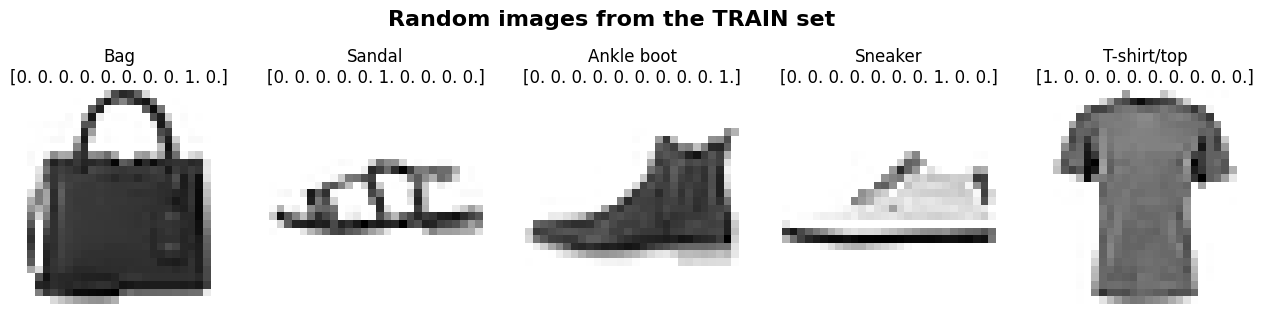

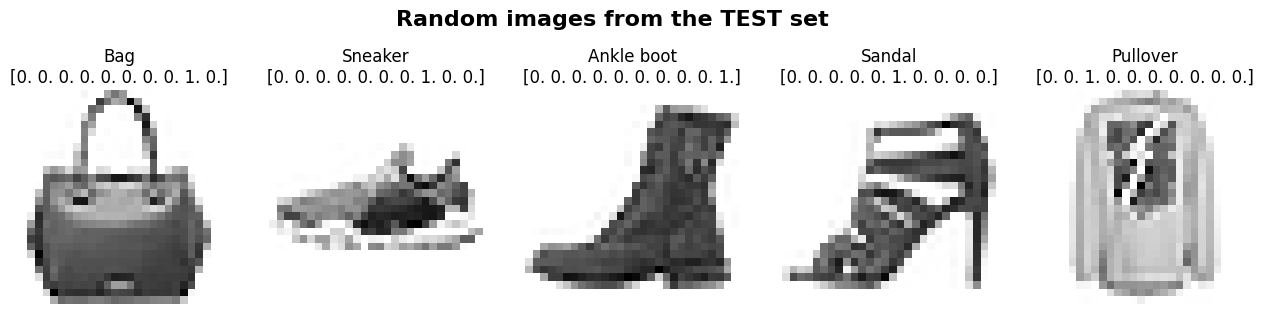

In [5]:
PATH = os.path.join('data_hw2', 'fashion_mnist_npy')

label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train = np.load(os.path.join(PATH, 'train_data.npy'))
X_test = np.load(os.path.join(PATH, 'test_data.npy'))
Y_train = np.load(os.path.join(PATH, 'train_labels.npy'))
Y_test = np.load(os.path.join(PATH, 'test_labels.npy'))

num_classes = len(label_names)
num_trains, HEIGHT, WIDTH = X_train.shape

X_train, X_test = reshape_train_data(X_train), reshape_train_data(X_test)

Y_train, Y_test = one_hot_vector(Y_train, num_classes), one_hot_vector(Y_test, num_classes)

fig_train, ax_train = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_train.suptitle("Random images from the TRAIN set", y=0.73, fontsize=16, fontweight='bold')

fig_test, ax_test = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_test.suptitle("Random images from the TEST set", y=0.73, fontsize=16, fontweight='bold')

np.random.seed(666)
for idx in range(5):
    i, j = np.random.randint(num_trains), np.random.randint(X_test.shape[0])

    ax_train[idx].imshow(X_train[:,i].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_train[idx].set_title(label_names[np.argmax(Y_train[:,i])] + "\n" + str(Y_train[:,i]))
    ax_train[idx].axis('off')

    ax_test[idx].imshow(X_test[:,j].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_test[idx].set_title(label_names[np.argmax(Y_test[:,j])] + "\n" + str(Y_test[:,j]))
    ax_test[idx].axis('off')

## Stage 2: Building the Neural Network and Implementing Propagation
#### Deep Dive into Neural Network Mechanics.
The loss function quantifies the discrepancy between predicted and actual values. It's crucial for training NNs as it guides the optimization process by calculating gradients. These gradients are then used in conjunction with optimization algorithms like gradient descent to update network parameters (weights and biases), iteratively refining the model.

This process can be visualized as calculating the 'error' at the output layer using the loss function, and then propagating this error back through the network's layers. During backpropagation, the contribution of each parameter to the error is computed, allowing for parameter adjustments that minimize the loss.

![Figure1.png](http://yty.kapsi.fi/DLcourse/ass2/Figure1.png)

<center> <strong> <font size="3" color="red"> Figure 1. Backpropagation Example </font> </strong> </center>

Figure 1 illustrates a loss function $L = c \times d$, where $c = a + b -5$ and $d = b^2 + b -1$. The derivatives on edges show partial derivatives. Chain rule helps calculate $\frac{\partial L}{\partial a}$ and $\frac{\partial L}{\partial b}$: 

\begin{align}
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial c} \cdot \frac{\partial c}{\partial a}
\end{align}

and <br>

\begin{align}
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial c} \cdot \frac{\partial c}{\partial b} + \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial b}
\end{align}

This highlights how variable $a$ impacts $L$ via $c$, a principle consistent in complex networks with numerous layers and intricate losses, as long as backpropagation guides weight updates.

**Hands-on Neural Network Implementation.**

### 2.1 Exploring Dataset Structure

Understanding input data structure is essential. The following code block displays the dimensions of training and test sets.

In [6]:
print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of Y_test:', Y_test.shape)

Shape of X_train: (784, 60000)
Shape of Y_train: (10, 60000)
Shape of X_test: (784, 10000)
Shape of Y_test: (10, 10000)


### 2.2 Model Construction and Forward Propagation

**Figure 2** illustrates the architecture of our neural network.


![Figure2.png](http://yty.kapsi.fi/DLcourse/ass2/Figure2.png)

<center> <strong> <font size="4" color="red"> Figure 2. Simple Feed-Forward Neural Network Architecture </font> </strong> </center>

### Parameter Initialization

Our network (Figure 2) has two hidden layers with 10 and 6 neurons respectively, plus an output layer. Biases are excluded for simplicity. Hidden layer neuron count is flexible, but the output layer must have 10 neurons for classifying 10 Fashion-MNIST classes. 

The following sections detail the construction based on **Figure 2**.

Defining default neural network parameters.

In [7]:
num_inputs = X_train.shape[0]

num_hidden_1 = 10
num_hidden_2 = 6

num_outputs = num_classes

Randomly initializing network parameters to shape **(out_dim, in_dim)**, representing layer output and input dimensions.

In [8]:
def init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs):
    """Initializes model parameters and momentum learning velocity.

    Returns:
        parameters (tuple): Model parameters: W1, W2, W3
        velocity (tuple): Momentum learning velocity: V_dW1, V_dW2, V_dW3
    """

    W1 = np.random.randn(num_hidden_1, num_inputs)
    W2 = np.random.randn(num_hidden_2, num_hidden_1)
    W3 = np.random.randn(num_outputs, num_hidden_2)

    parameters = W1, W2, W3

    V_dW1 = np.zeros(W1.shape)
    V_dW2 = np.zeros(W2.shape)
    V_dW3 = np.zeros(W3.shape)

    velocity = V_dW1, V_dW2, V_dW3

    return parameters, velocity

Output shape verification.

In [9]:
parameters, velocity = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)

W1, W2, W3 = parameters

print('Shape of W1:', W1.shape)
print('Shape of W2:', W2.shape)
print('Shape of W3:', W3.shape)

Shape of W1: (10, 784)
Shape of W2: (6, 10)
Shape of W3: (10, 6)


Shape Verification: W1: (10, 784), W2: (6, 10), W3: (10, 6).

### Defining Activation Functions

Activation functions introduce non-linearity to the network. We'll use Tanh, ReLU, and Softmax:

The Tanh (hyperbolic tangent) activation:

$$
{\rm tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
\tag{1}
$$

The ReLU (Rectified Linear Unit) activation:

$$
{\rm ReLU}(x) = \text{max}(x, 0) =
\begin{cases}
x, & \text{if}\ x > 0 \\
0, & \text{otherwise}
\end{cases}
\tag{2}
$$

The Softmax activation (for multi-class probability distribution):

$$
{\rm softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{N}e^{x_j}}\ \text{for}\ i\ \text{in}\ \left\{1,...,N \right\}
\tag{3}
$$

where $N$ is the number of classes.

In [10]:
def tanh(X):
    return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))

def relu(X):
    return np.maximum(0, X)

def softmax(X):
    exp_X = np.exp(X)
    return exp_X / np.sum(exp_X, axis=0, keepdims=True)

Verifying activation function outputs.

In [11]:
X = np.array([-1, 0, 2]).reshape(-1, 1)

print('X')
print(X, '\n')

print('tanh(x)')
print(tanh(X), '\n')

print('relu(x)')
print(relu(X), '\n')

print('softmax(x)')
print(softmax(X))

X
[[-1]
 [ 0]
 [ 2]] 

tanh(x)
[[-0.76159416]
 [ 0.        ]
 [ 0.96402758]] 

relu(x)
[[0]
 [0]
 [2]] 

softmax(x)
[[0.04201007]
 [0.1141952 ]
 [0.84379473]]


Activation function output example:
tanh(x):
[[-0.76159416], [ 0.], [ 0.96402758]]

relu(x):
[[0], [0], [2]]

softmax(x):
[[0.04201007], [0.1141952 ], [0.84379473]]

Visualizing Tanh and ReLU activation functions.

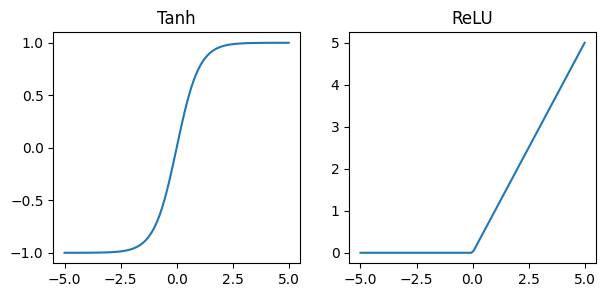

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

x = np.linspace(-5, 5, 100).reshape(-1, 1)

ax[0].set_title('Tanh')
ax[0].plot(x, tanh(x))

ax[1].set_title('ReLU')
ax[1].plot(x, relu(x))

### Implementing Forward Propagation

Forward propagation in our model involves three steps based on **Figure 2**:

1. **First Hidden Layer Activation** ($A_1$) with ReLU:

$$
\begin{align}
Z_1 &= W_1 X \tag{4} \\
A_1 &= {\rm ReLU}(Z_1) \tag{5}
\end{align}
$$

2. **Second Hidden Layer Activation** ($A_2$) with Tanh:

$$
\begin{align}
Z_2 &= W_2 A_1 \tag{6} \\
A_2 &= {\rm tanh}(Z_2) \tag{7}
\end{align}
$$

3. **Output Layer Activation** ($A_3$) with Softmax:

$$
\begin{align}
Z_3 &= W_3 A_2 \tag{8} \\
A_3 &= {\rm softmax}(Z_3) \tag{9}
\end{align}
$$

$A_3$ provides class probabilities for classification.

Function for implementing forward propagation.

In [13]:
def forward_propagation(X, parameters):
    """Forward propagation method.
    Args:
        X (np.array): Input data
        parameters (tuple): Model parameters: W1, W2, W3

    Returns:
        outputs (tuple): Cached forward propagation outputs: Z1, A1, Z2, A2, Z3, A3
    """

    W1, W2, W3 = parameters

    Z1 = np.matmul(W1, X)
    A1 = relu(Z1)
    Z2 = np.matmul(W2, A1)
    A2 = tanh(Z2)
    Z3 = np.matmul(W3, A2)
    A3 = softmax(Z3)

    outputs = Z1, A1, Z2, A2, Z3, A3
    return outputs

Verifying forward propagation output shapes and values.

In [14]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X, parameters)

print('Shape of X:', X.shape)
print('Shape of Z1:', Z1.shape)
print('Shape of A1:', A1.shape)
print('Shape of Z2:', Z2.shape)
print('Shape of A2:', A2.shape)
print('Shape of Z3:', Z3.shape)
print('Shape of A3:', A3.shape)

print('\nExample results of A3:')
print(A3)

Shape of X: (784, 2)
Shape of Z1: (10, 2)
Shape of A1: (10, 2)
Shape of Z2: (6, 2)
Shape of A2: (6, 2)
Shape of Z3: (10, 2)
Shape of A3: (10, 2)

Example results of A3:
[[1.38202775e-03 4.52205629e-04]
 [6.15985645e-05 3.82649723e-04]
 [1.48498984e-03 2.77106027e-03]
 [3.63232325e-02 2.61529866e-04]
 [4.89499804e-01 3.33523685e-03]
 [5.90058174e-02 3.56606147e-03]
 [3.93312146e-03 7.51254172e-03]
 [1.09048918e-04 1.57395365e-04]
 [4.05891483e-01 5.70850621e-03]
 [2.30887617e-03 9.75852813e-01]]


Output Shape and Value Examples:
X: (784, 2), Z1: (10, 2), A1: (10, 2), Z2: (6, 2), A2: (6, 2), Z3: (10, 2), A3: (10, 2).

A3 Example:
[[1.38202775e-03, 4.52205629e-04],
 [6.15985645e-05, 3.82649723e-04],
 [1.48498984e-03, 2.77106027e-03],
 [3.63232325e-02, 2.61529866e-04],
 [4.89499804e-01, 3.33523685e-03],
 [5.90058174e-02, 3.56606147e-03],
 [3.93312146e-03, 7.51254172e-03],
 [1.09048918e-04, 1.57395365e-04],
 [4.05891483e-01, 5.70850621e-03],
 [2.30887617e-03, 9.75852813e-01]]

### 2.3 Loss Function and Backward Propagation

### Cross-Entropy Loss Implementation

Cross-entropy measures the difference between probability distributions, here between predicted and true labels. Formula:

$$
L = {\rm cross\_entropy}(Y, A_3) = - \frac{1}{M} \sum_{k=0}^{M} \sum_{i=0}^{N} Y_i^{k} log({A_3}_i^{k}) \tag{10}
$$
Y: true labels, $A_3$: predictions, $N$: classes, $M$: batch size.

Implementing the cross-entropy loss function.

In [15]:
def cross_entropy_loss(Y, Y_pred):
    m = Y.shape[1]
    return -np.sum(np.multiply(Y, np.log(Y_pred))) / m

Verifying cross-entropy loss output.

In [16]:
np.random.seed(1)
Y = one_hot_vector(np.random.randint(1, num_classes, 2), num_classes)
A3 = softmax(np.random.randn(num_classes, 2))

L = cross_entropy_loss(Y, A3)
print('Shape of Y:', Y.shape)
print('Shape of A3:', A3.shape)
print('Loss:', L)

Shape of Y: (10, 2)
Shape of A3: (10, 2)
Loss: 1.4200061694735258


Loss output example:
Y: (10, 2), A3: (10, 2), Loss: 1.4200061694735258.

### Backward Propagation Implementation

Backward propagation computes gradients for parameter updates to minimize the loss. It uses chain rule to find derivatives with respect to weights.

We aim to calculate $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial W_2}$ and $\frac{\partial L}{\partial W_3}$:

$$
\frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial W_3} \tag{11}
$$

,

$$
\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial W_2} \tag{12}
$$

and

$$
\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} \cdot \frac{\partial Z_2} {\partial A_1} \cdot \frac{\partial A_1}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial W_1} \tag{13}
$$

Derivatives in matrix form are provided below for implementation.

From **Eq. 11**: Derivatives w.r.t $Z_3$ and $W_3$:

Derivative of $L$ w.r.t $Z_3$:

$$
dZ_3 = \frac{\partial L}{\partial Z_3} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} = A_3 - Y \tag{14}
$$

Derivative of $L$ w.r.t $W_3$:

$$
d W_3 = \frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial W_3} = \frac{1}{m} d Z_3 \cdot A_2^T \tag{15}
$$

where $m$ is the mini-batch size.

From **Eq. 12**: Derivatives w.r.t $A_2$, $Z_2$ and $W_2$:

Derivative of $L$ w.r.t $A_2$:
$$
d A_2 = \frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial A_2} = W_3^T \cdot (A_3 - Y) \tag{16}
$$

Derivative of $L$ w.r.t $Z_2$ (using tanh derivative):

$$
\frac{d}{d x}tanh(x)=1-tanh^2(x) \:\:\: \longrightarrow \:\:\:\frac{\partial A_2}{\partial Z_2} = 1 - (A_2)^2 \tag{17}
$$

$$
d Z_2 = \frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} = d A_2 * (1 - (A_2)^2 ) \tag{18}
$$

Derivative of $L$ w.r.t $W_2$:
$$
d W_2 = \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial W_2} = \frac{1}{m} d Z_2 \cdot A_1^T \tag{19}
$$



From **Eq. 13**: Derivatives w.r.t $A_1$, $Z_1$ and $W_1$:

Derivative of $L$ w.r.t $A_1$:
$$
d A_1 = \frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial A_1} = W_2^T \cdot d Z_2\tag{20}
$$

Derivative of $L$ w.r.t $Z_1$ (using ReLU derivative):
$$
\frac{\partial A_1}{\partial Z_1} = {\rm int}(A1 > 0) \tag{21}
$$

$$
d Z_1 = \frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \cdot \frac{\partial A_1}{\partial Z_1} = d A_1 * {\rm int}(A1 > 0) \tag{22}
$$

Derivative of $L$ w.r.t $W_1$:
$$
d W_1 = \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial W_1} = \frac{1}{m} d Z_1 \cdot X^T \tag{23}
$$



**Implementation Notes:**

- Matrix multiplication: `np.matmul(A, B)`.
- Element-wise product (Hadamard product): `np.multiply(A, B)` or `A * B`.
- Transpose: `A.T`.
- Boolean to integer conversion: `A.astype(int)`.
- $m$: mini-batch size.

In [17]:
def backward_propagation(X, Y, parameters, outputs):
    """Backward propagation method.
    Args:
        X (np.array): Input data
        Y (np.array): True labels
        parameters (tuple): Model parameters: W1, W2, W3
        outputs (tuple): Cached forward propagation outputs: Z1, A1, Z2, A2, Z3, A3

    Returns:
        tuple: Computed gradients: dW1, dW2, dW3
    """

    m = X.shape[1]

    W1, W2, W3 = parameters
    Z1, A1, Z2, A2, Z3, A3 = outputs

    dZ3 = A3 - Y
    dW3 = (1 / m) * np.matmul(dZ3, A2.T)

    dA2 = np.matmul(W3.T, dZ3)
    dZ2 = dA2 * (1-A2**2)
    dW2 = (1 / m) * np.matmul(dZ2, A1.T)

    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * (A1 > 0).astype(int)
    dW1 = (1 / m) * np.matmul(dZ1, X.T)

    return dW1, dW2, dW3

Verifying backward propagation output shapes and values.

In [18]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)
Y = np.random.randint(1, num_classes, (2, ))

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
outputs = forward_propagation(X, parameters)
dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)

print('Shape of dW3:', dW3.shape)
print('Shape of dW2:', dW2.shape)
print('Shape of dW1:', dW1.shape)

print('\nExample results in dW3:')
print(dW3[:, 0])

print('\nExample results in dW2:')
print(dW2[:, 0])

print('\nExample results in dW1:')
print(dW1[:, 0])

Shape of dW3: (10, 6)
Shape of dW2: (6, 10)
Shape of dW1: (10, 784)

Example results in dW3:
[4.9942051  4.80999429 4.51023899 4.99772104 4.93469564 4.99419688
 4.81378453 4.98266546 4.99669364 4.96580443]

Example results in dW2:
[ 0.00000000e+00  0.00000000e+00 -1.25890118e-12  0.00000000e+00
 -1.62841039e-11  0.00000000e+00]

Example results in dW1:
[-1.45284316e-12  0.00000000e+00  4.73647801e-13 -2.40991086e-10
 -4.70147641e-12  0.00000000e+00  2.25983992e-10  0.00000000e+00
  7.74600535e-12  6.12156451e-11]


Output Shape and Value Examples:
dW3: (10, 6), dW2: (6, 10), dW1: (10, 784).

dW3 Example:
[4.9942051, 4.80999429, 4.51023899, 4.99772104, 4.93469564, 4.99419688,
 4.81378453, 4.98266546, 4.99669364, 4.96580443]

dW2 Example:
[0.0, 0.0, -1.25890118e-12, 0.0, -1.62841039e-11, 0.0]

dW1 Example:
[-1.45284316e-12, 0.0, 4.73647801e-13, -2.40991086e-10, -4.70147641e-12, 0.0,
 2.25983992e-10, 0.0, 7.74600535e-12, 6.12156451e-11]

### Exploring Gradient Checking with Finite-Difference Approximation

Gradient calculation correctness is crucial in neural network training. Incorrect gradients can lead to unusual model behavior and are challenging to debug. Gradient checking helps verify gradient accuracy using finite-difference approximation (FDA).

FDA approximates derivative using the formula:
\begin{align}
\Delta_{num\_grad} f = \frac{f(x + \epsilon) - f(x - \epsilon)}{2 * \epsilon}  \tag{26}
\end{align}
where $\epsilon$ is a small value (e.g., $1e-{04}$). By comparing numerical gradients from FDA with analytical gradients (derivatives), we can ensure backpropagation implementation accuracy.

## Stage 3: Training and Evaluating the Neural Network

### 3.1 Network Training Process

We'll use mini-batch gradient descent with momentum for training:

Velocity update:
$$
v_{dW} = \beta v_{dW} + (1 - \beta) dW \tag{28}
$$

Weight update:
$$
W = W - \alpha v_{dW} \tag{29}
$$
$\alpha$: learning rate, $\beta$: momentum coefficient.

Training step function implementation (forward propagation to parameter update).

In [19]:
def training_step(X, Y, parameters, velocity, learning_rate, beta, weight_decay_lambda=0.):
    """Single training step method.
    Args:
        X (np.array): Training data
        Y (np.array): True labels
        parameters (tuple): Model parameters: W1, W2, W3
        velocity (tuple): Momentum velocity: V_dW1, V_dW2, V_dW3
        learning_rate (float): Learning rate
        beta (float): Momentum coefficient
        weight_decay_lambda (float): Weight decay coefficient (regularization)

    Returns:
        tuple: Loss, updated parameters, updated velocity
    """

    W1, W2, W3 = parameters

    outputs = forward_propagation(X, parameters)
    A3 = outputs[-1]

    if weight_decay_lambda == 0.:
        loss = cross_entropy_loss(Y, A3)
        dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)
    else:
        loss = cross_entropy_loss(Y, A3) + weight_decay_loss(parameters, weight_decay_lambda)
        dW1, dW2, dW3 = backward_propagation_with_weight_decay(X, Y, parameters, outputs, weight_decay_lambda)

    V_dW1, V_dW2, V_dW3 = velocity

    V_dW1 = beta * V_dW1 + (1 - beta) * dW1
    V_dW2 = beta * V_dW2 + (1 - beta) * dW2
    V_dW3 = beta * V_dW3 + (1 - beta) * dW3

    W1 = W1 - learning_rate * V_dW1
    W2 = W2 - learning_rate * V_dW2
    W3 = W3 - learning_rate * V_dW3

    parameters = W1, W2, W3
    velocity = V_dW1, V_dW2, V_dW3

    return loss, parameters, velocity

Function to train the neural network over epochs.

In [20]:
def training_model(parameters, velocity, batch_size, epoch, learning_rate, beta, weight_decay_lambda=0.):

    num_batches = num_trains // batch_size
    print('Start training the model:')
    print('Number of training samples: {}'.format(num_trains))
    print('Number of batchs: {}'.format(num_batches))

    loss_log = []

    for i in range(epoch):
        start_t = time.time()

        indices = np.random.permutation(num_trains)
        X_train_shuffled, Y_train_shuffled = X_train[:, indices], Y_train[:, indices]

        for j in range(num_batches):

            start_idx, end_idx = j * batch_size, min(j * batch_size + batch_size, X_train.shape[1] - 1)
            X, Y = X_train_shuffled[:, start_idx : end_idx], Y_train_shuffled[:, start_idx : end_idx]

            loss, parameters, velocity = training_step(X, Y, parameters, velocity, learning_rate, beta, weight_decay_lambda)

            loss_log.append(loss)
            if (j > 0 and j % 200 == 0):
                print("[Epoch][Iterations]:[{}/{}][{}/{}], loss: {}".format(i, epoch, j, num_batches, loss))

        print("=> Epoch {}, elapsed time: {:.2f} seconds".format(i, time.time() - start_t))

    plt.title('Training loss:')
    plt.plot(loss_log)
    plt.show()

    return parameters

Initializing and training the model with default settings.

Start training the model:
Number of training samples: 60000
Number of batchs: 468
[Epoch][Iterations]:[0/30][200/468], loss: 1.3539317078847701
[Epoch][Iterations]:[0/30][400/468], loss: 1.1611606072419878
=> Epoch 0, elapsed time: 4.96 seconds
[Epoch][Iterations]:[1/30][200/468], loss: 1.1555913741849602
[Epoch][Iterations]:[1/30][400/468], loss: 0.9523556786404768
=> Epoch 1, elapsed time: 3.50 seconds
[Epoch][Iterations]:[2/30][200/468], loss: 0.9677024114710594
[Epoch][Iterations]:[2/30][400/468], loss: 0.9293388248532337
=> Epoch 2, elapsed time: 1.80 seconds
[Epoch][Iterations]:[3/30][200/468], loss: 0.9230688992858795
[Epoch][Iterations]:[3/30][400/468], loss: 0.9894624824971912
=> Epoch 3, elapsed time: 2.10 seconds
[Epoch][Iterations]:[4/30][200/468], loss: 0.8305793142557805
[Epoch][Iterations]:[4/30][400/468], loss: 0.8990161692680599
=> Epoch 4, elapsed time: 2.23 seconds
[Epoch][Iterations]:[5/30][200/468], loss: 0.9943809350321016
[Epoch][Iterations]:[5/30][400/468], loss

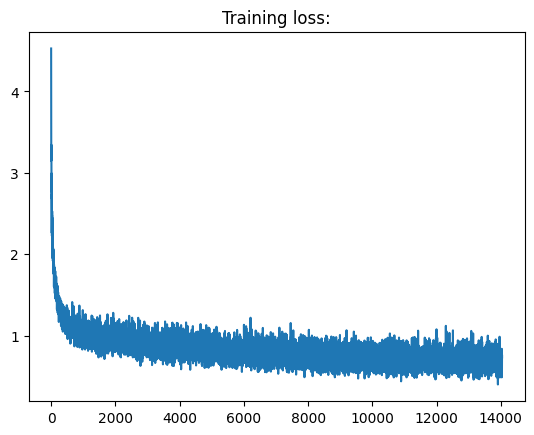

In [21]:
np.random.seed(1)

parameters, velocity = init_parameters(
    num_inputs = X_train.shape[0],
    num_hidden_1 = 10,
    num_hidden_2 = 6,
    num_outputs = num_classes,
)

trained_parameters = training_model(
    parameters,
    velocity,
    batch_size = 128,
    epoch = 30,
    learning_rate = 0.25,
    beta = 0.5,
    weight_decay_lambda = 0.,
)

### 3.2 Model Performance Evaluation

Implementing forward propagation for model evaluation on test data.

In [22]:
def testing_model(X, parameters):
    A3 = forward_propagation(X, parameters)[-1]

    predictions = np.argmax(A3, axis=0)
    labels = np.argmax(Y_test, axis=0)

    print("Confusion matrix:\n{}\n".format(confusion_matrix(labels, predictions)))
    print("Test accuracy: {}".format(accuracy_score(labels, predictions)))

Evaluating model accuracy on the test set.

In [23]:
testing_model(X_test, trained_parameters)

Confusion matrix:
[[888   5  20  55   3   0   3   0  26   0]
 [  3 916  14  56   8   0   0   0   3   0]
 [ 34   2 868   9  45   1   3   0  38   0]
 [ 88   7  19 794  65   0   2   0  25   0]
 [  3   2 730  20 204   0   3   0  38   0]
 [  0   0   0   1   4 836   0  72  11  76]
 [316   3 559  43  29   0   6   0  44   0]
 [  0   0   0   0   0  69   0 882   0  49]
 [  5   0  13   9   5   2   1   5 959   1]
 [  0   0   0   0   3  41   0  47   1 908]]

Test accuracy: 0.7261


Expected test accuracy around 0.70 with default parameters.

## Stage 4: Regularization and Hyperparameter Tuning

### 4.1 Implementing Weight Decay for Regularization

Regularization techniques, like weight decay, prevent overfitting by penalizing model complexity, promoting better generalization.

Weight decay (L2 regularization) modifies the loss function:

$$
\begin{align}
L &= L_1 + L_2 \tag{30} \\
\\
L_1 &= {\rm cross\_entropy}(Y, A_3) \tag{31} \\
L_2 &= \frac{\lambda}{2} \left( ||W_1||_2^2 + ||W_2||_2^2 + ||W_3||_2^2 \right) \tag{32}
\end{align}
$$
$L_2$: weight decay loss, $||\cdot||_2^2$: L2 norm.

Implementing weight decay loss function.

In [24]:
def weight_decay_loss(parameters, lambd):
    """
    Args:
        parameters (tuple): Model parameters: W1, W2, W3
        lambd (float): Weight decay coefficient
    """
    W1, W2, W3 = parameters

    return (lambd / 2) * (np.sum(np.power(W1, 2)) + np.sum(np.power(W2, 2)) + np.sum(np.power(W3, 2)))

Verifying weight decay loss output.

In [25]:
np.random.seed(1)
parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)

loss = weight_decay_loss(parameters, lambd=0.0001)
print('loss:', loss)

loss: 0.3972738208879281


Weight decay loss output example: 0.3972738208879281.

Updated backward propagation for weight decay, modifying derivatives.

Backward propagation function with weight decay.

In [26]:
def backward_propagation_with_weight_decay(X, Y, parameters, outputs, lambd):
    """Backward propagation with weight decay.
    Args:
        X (np.array): Input data
        Y (np.array): True labels
        parameters (tuple): Model parameters: W1, W2, W3
        outputs (tuple): Cached forward propagation outputs
        lambd (float): Weight decay coefficient

    Returns:
        tuple: Gradients: dW1, dW2, dW3
    """

    W1, W2, W3 = parameters
    dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)

    dW1_new = dW1 + lambd * W1
    dW2_new = dW2 + lambd * W2
    dW3_new = dW3 + lambd * W3

    return dW1_new, dW2_new, dW3_new

Verifying backward propagation with weight decay output.

In [27]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)
Y = np.random.randint(1, num_classes, (2, ))

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
outputs = forward_propagation(X, parameters)
dW1_new, dW2_new, dW3_new = backward_propagation_with_weight_decay(X, Y, parameters, outputs, lambd=0.0001)

print('\nExample results in dW3 (new):')
print(dW3_new[:, 0])

print('\nExample results in dW2 (new):')
print(dW2_new[:, 0])

print('\nExample results in dW1 (new):')
print(dW1_new[:, 0])


Example results in dW3 (new):
[4.99417602 4.81002709 4.51013425 4.99769988 4.93467474 4.99422092
 4.81371188 4.98254415 4.99662634 4.96574142]

Example results in dW2 (new):
[ 1.78778996e-04  1.80471533e-05  5.78735665e-05 -7.65603509e-05
  3.89918617e-05  5.60040836e-06]

Example results in dW1 (new):
[ 5.51204348e-05  1.89067615e-05 -1.87286483e-05 -2.72250057e-05
  2.10901799e-04  1.05074359e-04 -3.10534150e-05  4.55281440e-05
  7.14239094e-05  1.88094599e-04]


Output Examples with Weight Decay:
dW3 (new): [4.99417602, 4.81002709, 4.51013425, 4.99769988, 4.93467474, 4.99422092, 4.81371188, 4.98254415, 4.99662634, 4.96574142]
dW2 (new): [1.78778996e-04, 1.80471533e-05, 5.78735665e-05, -7.65603509e-05, 3.89918617e-05, 5.60040836e-06]
dW1 (new): [5.51204348e-05, 1.89067615e-05, -1.87286483e-05, -2.72250057e-05, 2.10901799e-04, 1.05074359e-04, -3.10534150e-05, 4.55281440e-05, 7.14239094e-05, 1.88094599e-04]

### 4.2 Hyperparameter Tuning

Hyperparameter tuning optimizes model performance by adjusting settings like learning rate, batch size, regularization strength, and network architecture.

Experiment with hyperparameters to enhance network accuracy beyond 0.80.

Start training the model:
Number of training samples: 60000
Number of batchs: 468
[Epoch][Iterations]:[0/30][200/468], loss: 5.130965981045569
[Epoch][Iterations]:[0/30][400/468], loss: 4.913920839295915
=> Epoch 0, elapsed time: 2.02 seconds
[Epoch][Iterations]:[1/30][200/468], loss: 4.211148127794477
[Epoch][Iterations]:[1/30][400/468], loss: 3.9773536929653592
=> Epoch 1, elapsed time: 1.87 seconds
[Epoch][Iterations]:[2/30][200/468], loss: 3.5539465854030388
[Epoch][Iterations]:[2/30][400/468], loss: 3.3318490930023668
=> Epoch 2, elapsed time: 1.61 seconds
[Epoch][Iterations]:[3/30][200/468], loss: 2.989872582716207
[Epoch][Iterations]:[3/30][400/468], loss: 2.7486025811802195
=> Epoch 3, elapsed time: 1.61 seconds
[Epoch][Iterations]:[4/30][200/468], loss: 2.373340420460183
[Epoch][Iterations]:[4/30][400/468], loss: 2.12202708424217
=> Epoch 4, elapsed time: 1.81 seconds
[Epoch][Iterations]:[5/30][200/468], loss: 1.9824726444329885
[Epoch][Iterations]:[5/30][400/468], loss: 1.807

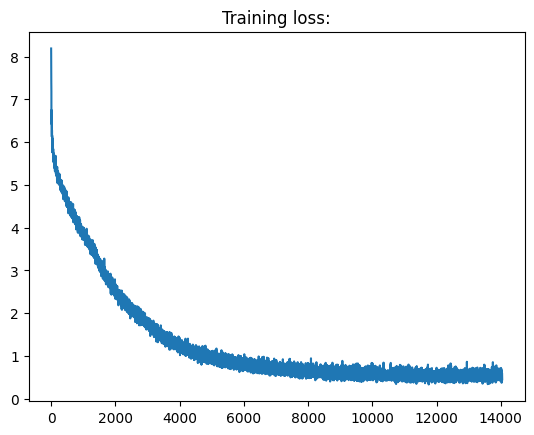

In [28]:
parameters, velocity = init_parameters(
    num_inputs = X_train.shape[0],
    num_hidden_1 = 10,
    num_hidden_2 = 6,
    num_outputs=num_classes
)

trained_parameters = training_model(
    parameters,
    velocity,
    batch_size = 128,
    epoch = 30,
    learning_rate = 0.25,
    beta = 0.5,
    weight_decay_lambda = 0.001,
)

In [29]:
testing_model(X_test, trained_parameters)

Confusion matrix:
[[839   0  21  31   2   0  88   0  19   0]
 [  8 940   4  36   7   0   3   0   2   0]
 [ 17   1 676   9 203   0  86   0   8   0]
 [ 49   3  14 859  40   0  32   0   3   0]
 [  0   0  58  28 815   0  93   0   6   0]
 [  1   0   0   1   1 876   0  50  28  43]
 [201   0 101  26  91   0 553   0  28   0]
 [  0   0   0   0   0  16   0 972   0  12]
 [  0   0   5   7   7   2  14   4 961   0]
 [  0   0   0   0   0  16   0  74   3 907]]

Test accuracy: 0.8398


Expected test accuracy: 0.80 or higher with optimized hyperparameters.